In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 16.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import shutil

In [8]:
input_dir = '/kaggle/input/number-plate-detection/images'  
jpeg_dir = '/kaggle/working/jpeg_files'
xml_dir = '/kaggle/working/xml_files'

os.makedirs(jpeg_dir, exist_ok=True)
os.makedirs(xml_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith('.jpeg'):
        shutil.copy(os.path.join(input_dir, filename), os.path.join(jpeg_dir, filename))
    elif filename.endswith('.xml'):
        shutil.copy(os.path.join(input_dir, filename), os.path.join(xml_dir, filename))

In [9]:
len([filename for filename in os.listdir(jpeg_dir) if filename.endswith('.jpeg')])

228

In [10]:
len([filename for filename in os.listdir(xml_dir) if filename.endswith('.xml')])

225

3 extra jpeg!!!

In [16]:
dataset = '/kaggle/working/dataset'
train_images_dir = dataset+'/images/train'
test_images_dir = dataset+'/images/test'
train_labels_dir = dataset+'/labels/train'
test_labels_dir = dataset+'/labels/test'

os.makedirs(train_images_dir, exist_ok= True)
os.makedirs(test_labels_dir, exist_ok= True)
os.makedirs(train_labels_dir, exist_ok= True)
os.makedirs(test_images_dir, exist_ok= True)

In [20]:
import xml.etree.ElementTree as ET

# function to convert to compatible type
def convert_voc_to_yolo(xml_file, img_width, img_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    yolo_data = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        class_id = 0  

        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Convert to YOLO format
        x_center = (xmin + xmax) / 2 / img_width
        y_center = (ymin + ymax) / 2 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        yolo_data.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_data

In [22]:
import random
import cv2

image_files = []

for filename in os.listdir(jpeg_dir):
    if filename.endswith('.jpeg'):
        image_files.append(filename)

random.shuffle(image_files)

split_index = int(len(image_files) * 0.9)
# train - test - split
train_files = image_files[:split_index]
val_files = image_files[split_index:]

for filename in train_files + val_files:
    image_path = os.path.join(jpeg_dir, filename)

    if filename in train_files:
        target_image_dir = train_images_dir
        target_label_dir = train_labels_dir
    else:
        target_image_dir = test_images_dir
        target_label_dir = test_labels_dir

    shutil.copy(image_path, os.path.join(target_image_dir, filename))

    xml_file_path = os.path.join(xml_dir, os.path.splitext(filename)[0] + '.xml')

    if os.path.exists(xml_file_path):
        img = cv2.imread(image_path)
        img_height, img_width, _ = img.shape

        yolo_labels = convert_voc_to_yolo(xml_file_path, img_width, img_height)
        label_file_path = os.path.join(target_label_dir, f"{os.path.splitext(filename)[0]}.txt")

        with open(label_file_path, 'w') as f:
            for line in yolo_labels:
                f.write(line + '\n')
    else:
        print(f"No XML file found for {filename}, skipping label generation.")   # 3 extra jpeg present

print("Dataset structure created with train and validation sets.")

No XML file found for N182.jpeg, skipping label generation.
No XML file found for N249.jpeg, skipping label generation.
No XML file found for N180.jpeg, skipping label generation.
Dataset structure created with train and validation sets.


In [27]:
# creting .yaml file for YOLO training
yaml_content = """train: /kaggle/working/dataset/images/train
val: /kaggle/working/dataset/images/test

nc: 1  # Number of classes
names: ['number_plate']  # List of class names
"""

with open(dataset + '/dataset.yaml', 'w') as file:
    file.write(yaml_content)

In [28]:
# training YOLOv8
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  

model.train(data='/kaggle/working/dataset/dataset.yaml', epochs=150, imgsz=640)

Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]
2024-11-03 19:54:16,025	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-03 19:54:17,002	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 63.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 225 images, 3 backgrounds, 0 corrupt: 100%|██████████| 228/228 [00:00<00:00, 962.08it/s]

train: New cache created: /kaggle/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/labels/test... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 1334.55it/s]

val: New cache created: /kaggle/working/dataset/labels/test.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.23G      1.486      3.496       1.39          7        640: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         23         23    0.00333          1      0.695      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.17G      1.286      2.002      1.163          4        640: 100%|██████████| 15/15 [00:02<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         23         23    0.00333          1      0.639      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.18G      1.279      1.718       1.16          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


                   all         23         23      0.386      0.478      0.365      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.18G      1.229      1.538      1.117          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


                   all         23         23      0.643       0.47      0.737      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.18G      1.218      1.428      1.153          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         23         23      0.473      0.478      0.414      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.18G      1.244      1.382      1.121          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all         23         23      0.667      0.652       0.61      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.17G      1.244      1.418      1.171          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


                   all         23         23     0.0984      0.739     0.0922     0.0612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.18G      1.312      1.341      1.204          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         23         23     0.0417      0.739     0.0412     0.0238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.18G      1.232      1.271      1.148         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


                   all         23         23     0.0414      0.739      0.044     0.0291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.18G      1.253       1.19      1.119          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


                   all         23         23      0.464      0.609      0.557        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.17G      1.164       1.09      1.138          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


                   all         23         23          1       0.98      0.995       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.18G      1.198      1.049      1.156         12        640: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         23         23      0.957          1      0.995      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.18G      1.159       1.04      1.128          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         23         23       0.99       0.87      0.935      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.18G      1.197     0.9442      1.167          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         23         23      0.911      0.957      0.948       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.17G      1.194     0.9578      1.152          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


                   all         23         23       0.94       0.87      0.924      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.18G      1.164     0.9437      1.136          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]

                   all         23         23      0.914      0.927      0.979      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.18G      1.121     0.8622      1.116          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


                   all         23         23          1      0.946      0.992      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.18G       1.14     0.8942      1.131          5        640: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


                   all         23         23      0.939          1      0.992      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.17G       1.15     0.8439      1.084          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


                   all         23         23      0.972      0.913      0.981      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.18G      1.209     0.8745      1.153          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         23         23       0.16       0.87       0.19       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.18G      1.155     0.8374      1.137          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         23         23      0.972      0.913      0.985      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.18G      1.135     0.8099      1.115          6        640: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         23         23      0.995          1      0.995      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.17G      1.192     0.8378      1.153          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         23         23          1      0.992      0.995      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.18G      1.185     0.8306      1.139         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         23         23      0.954      0.957      0.989      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.18G      1.093     0.7673      1.117         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

                   all         23         23      0.958      0.989      0.992      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.18G      1.049     0.7488      1.117          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         23         23          1      0.995      0.995      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.17G      1.045     0.7211      1.075          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         23         23      0.995      0.957       0.99      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.18G       1.04     0.7188      1.082          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         23         23      0.981      0.913      0.989      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.18G       1.13     0.7563      1.131          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


                   all         23         23      0.958      0.999      0.993      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.18G      1.054     0.7377       1.07          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         23         23      0.992          1      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.17G      1.043     0.6901      1.084          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         23         23      0.953          1      0.993      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.18G      1.013     0.7164       1.06          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


                   all         23         23      0.945          1      0.981      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.18G      1.079     0.6938        1.1          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         23         23      0.986          1      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.18G      1.071     0.6948      1.079          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         23         23      0.991          1      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.17G      1.097     0.7235      1.104         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         23         23          1      0.999      0.995      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.18G      1.013     0.6542      1.041          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         23         23          1      0.989      0.995      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.18G      1.014     0.6705      1.062          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         23         23      0.955          1      0.993      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.18G     0.9613     0.6402      1.018          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         23         23      0.997          1      0.995      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.17G     0.9759     0.6243      1.033          5        640: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         23         23      0.948          1      0.993      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.18G      1.013     0.6198      1.051         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         23         23          1      0.998      0.995      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.18G     0.9835     0.6243      1.038          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]

                   all         23         23          1      0.994      0.995      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.18G     0.9564     0.6202       1.03          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         23         23          1      0.983      0.995      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.17G      1.006      0.638       1.04         12        640: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         23         23      0.991          1      0.995      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.18G     0.9891     0.5913      1.063          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         23         23      0.993          1      0.995      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.18G      1.009     0.6133      1.042          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         23         23      0.996          1      0.995      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.18G       0.99     0.6415      1.052          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


                   all         23         23          1      0.998      0.995      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.17G     0.9591     0.5784      1.041          5        640: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


                   all         23         23          1      0.999      0.995      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.18G     0.9278     0.6003      1.004          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         23         23      0.993          1      0.995      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.17G     0.9432     0.6003      1.028          3        640: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         23         23      0.981          1      0.995      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.18G     0.9152     0.5802      1.005          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         23         23      0.995          1      0.995      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.17G     0.9529      0.585      1.056          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         23         23      0.996          1      0.995      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.17G     0.9786     0.5937      1.062          5        640: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         23         23      0.996          1      0.995      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.17G     0.9741     0.6046       1.02          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


                   all         23         23      0.996          1      0.995      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.18G      0.922     0.5904      1.019          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         23         23      0.993          1      0.995      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.17G     0.9419     0.5733      1.026          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         23         23       0.99          1      0.995      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.18G     0.9193     0.5662      1.014         11        640: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         23         23      0.992          1      0.995      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.18G     0.9132     0.5878      1.038          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         23         23       0.99          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.18G     0.8949     0.5767      1.012          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         23         23      0.995          1      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.17G     0.8948      0.519     0.9841         11        640: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         23         23      0.997          1      0.995      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.18G     0.8921     0.5251     0.9835          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         23         23          1      0.994      0.995      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.17G     0.9276     0.5682       1.03          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         23         23      0.997          1      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.18G     0.8765     0.5231     0.9984          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


                   all         23         23      0.995          1      0.995       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.17G     0.8681      0.539      1.002          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         23         23      0.999          1      0.995      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.17G     0.9138     0.5646     0.9859          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         23         23      0.998          1      0.995      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.18G      0.859     0.5369     0.9841          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


                   all         23         23      0.997          1      0.995      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.18G      0.867     0.5202      1.009          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         23         23      0.996          1      0.995       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.17G     0.8395     0.5462     0.9774         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         23         23      0.993          1      0.995      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.18G     0.8417     0.5103     0.9838          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         23         23      0.997          1      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.18G     0.8264     0.5104     0.9671          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         23         23      0.997          1      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.18G      0.835     0.5285     0.9859         11        640: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all         23         23      0.955          1      0.993      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.17G     0.8052     0.5466      1.002          5        640: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         23         23      0.995          1      0.995      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.18G     0.8287     0.4941     0.9789          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         23         23      0.993          1      0.995      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.17G     0.8657     0.5129     0.9836          5        640: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         23         23      0.995          1      0.995      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.18G     0.8243     0.5053     0.9787          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         23         23      0.996          1      0.995      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.17G     0.8296     0.5087     0.9764         12        640: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         23         23      0.997          1      0.995      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.18G      0.841     0.5031     0.9756         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         23         23      0.995          1      0.995      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.18G     0.8317     0.5197     0.9779         12        640: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         23         23      0.951          1       0.97      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.18G     0.8227     0.5097     0.9573          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

                   all         23         23      0.993          1      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.17G     0.7783     0.4839     0.9725         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

                   all         23         23      0.997          1      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.18G     0.8332     0.5091     0.9749          5        640: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         23         23      0.997          1      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.17G     0.7912     0.5055     0.9667          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         23         23      0.997          1      0.995       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.18G     0.7794     0.4769       0.95          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         23         23      0.996          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.17G      0.754     0.4795     0.9498          9        640: 100%|██████████| 15/15 [00:02<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all         23         23      0.995          1      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.18G     0.7555     0.4743     0.9628          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         23         23      0.994          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.18G     0.7463     0.4494     0.9587         11        640: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         23         23      0.997          1      0.995      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.18G     0.7638     0.4588     0.9491          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         23         23      0.996          1      0.995       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.17G     0.8092     0.4881     0.9713          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         23         23      0.997          1      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.18G     0.7809     0.4677     0.9519          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         23         23      0.997          1      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.18G     0.7517     0.4571     0.9516          5        640: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         23         23      0.997          1      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.18G     0.7307     0.4442     0.9379          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

                   all         23         23      0.997          1      0.995       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.17G     0.7321     0.4463      0.938          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         23         23      0.994          1      0.995      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.18G     0.7117     0.4709     0.9337          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         23         23      0.995          1      0.995      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.18G     0.7091     0.4426      0.944          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         23         23      0.996          1      0.995      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.18G     0.7787     0.4582     0.9621          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         23         23      0.989          1      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.17G     0.7058     0.4554     0.9255         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]

                   all         23         23      0.995          1      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.18G     0.7393     0.4594       0.97          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


                   all         23         23      0.997          1      0.995      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.18G     0.7528     0.4594     0.9534          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         23         23      0.997          1      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.18G     0.7258     0.4372     0.9376          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         23         23      0.997          1      0.995      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.17G     0.7215     0.4494       0.96          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         23         23      0.997          1      0.995       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.18G     0.6746     0.4374     0.9378          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         23         23      0.997          1      0.995      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.18G     0.7256     0.4637      0.958         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         23         23      0.998          1      0.995       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.18G     0.7046     0.4385     0.9259          5        640: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


                   all         23         23      0.998          1      0.995      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.17G     0.7006     0.4297     0.9298         13        640: 100%|██████████| 15/15 [00:02<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         23         23      0.998          1      0.995      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.17G     0.6661     0.4162     0.9281          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         23         23      0.998          1      0.995      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.18G     0.6971     0.4232     0.9156         13        640: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         23         23      0.997          1      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.18G     0.7477      0.445     0.9548         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         23         23      0.997          1      0.995      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.17G     0.7017     0.4225     0.9406          3        640: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


                   all         23         23      0.998          1      0.995      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.18G     0.6562     0.4041     0.9394          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         23         23      0.998          1      0.995      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.18G     0.6944     0.4236     0.9244          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         23         23      0.998          1      0.995      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.18G     0.7022     0.4349     0.9379          3        640: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         23         23      0.997          1      0.995      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.17G     0.6734     0.4164     0.9427          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         23         23      0.997          1      0.995      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.17G     0.6851     0.4099     0.9407          2        640: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         23         23      0.998          1      0.995      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.18G     0.6546     0.4193     0.9165          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         23         23      0.998          1      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.18G     0.6475     0.4068     0.9193         11        640: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         23         23      0.997          1      0.995      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.17G     0.6367     0.3984     0.9261          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all         23         23      0.997          1      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.18G     0.6529     0.4189     0.9163          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         23         23      0.997          1      0.995      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.17G     0.6595     0.4258      0.923          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         23         23      0.997          1      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.18G     0.6413     0.4035     0.9145          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         23         23      0.997          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.17G     0.6585     0.4168     0.9228         11        640: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         23         23      0.997          1      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.18G     0.6324     0.3932     0.9236         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         23         23      0.998          1      0.995      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.18G     0.6414     0.4013     0.9368          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         23         23      0.998          1      0.995      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.18G     0.6198     0.3859      0.895         10        640: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         23         23      0.998          1      0.995      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.17G     0.6057     0.4076     0.9163          3        640: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         23         23      0.998          1      0.995      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.18G     0.6148     0.3912     0.9038          5        640: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all         23         23      0.998          1      0.995      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.18G     0.6148     0.3747     0.8962          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


                   all         23         23      0.998          1      0.995      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.18G     0.6122     0.3848      0.898          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

                   all         23         23      0.997          1      0.995      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.17G     0.6152     0.3873     0.9092         11        640: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         23         23      0.997          1      0.995      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.18G     0.6085     0.3824      0.907          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         23         23      0.998          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.18G     0.5984     0.3836     0.9165          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         23         23      0.997          1      0.995      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.18G     0.5669     0.3632     0.8803         12        640: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         23         23      0.997          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.17G     0.5962     0.3905     0.9116          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         23         23      0.997          1      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.18G     0.5756     0.3682     0.9027          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         23         23      0.997          1      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.17G     0.5741     0.3748     0.9041          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


                   all         23         23      0.997          1      0.995       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.18G     0.5297     0.3568     0.8984          3        640: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]

                   all         23         23      0.997          1      0.995      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.17G     0.5502     0.3722     0.8855         12        640: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         23         23      0.997          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.18G     0.5759     0.3668     0.9001          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         23         23      0.997          1      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.17G     0.5525     0.3672     0.8998          6        640: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         23         23      0.997          1      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.18G     0.5767     0.3655     0.8952          7        640: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         23         23      0.997          1      0.995      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.17G     0.5486     0.3595     0.8745          8        640: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         23         23      0.997          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.18G     0.5497     0.3424     0.8887          9        640: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         23         23      0.997          1      0.995      0.899


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.17G     0.5154      0.345     0.8612          3        640: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


                   all         23         23      0.997          1      0.995       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.18G     0.5079     0.3275     0.8656          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         23         23      0.997          1      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.17G     0.5185     0.3147     0.8676          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

                   all         23         23      0.997          1      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.18G     0.5094     0.3075     0.8692          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all         23         23      0.997          1      0.995      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.17G     0.5016     0.3154     0.8594          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         23         23      0.997          1      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.17G      0.498     0.3074     0.8647          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         23         23      0.997          1      0.995      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.17G     0.4741     0.3054     0.8438          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         23         23      0.997          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.17G     0.4687     0.3001     0.8416          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         23         23      0.997          1      0.995      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.17G     0.4662     0.3082     0.8641          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


                   all         23         23      0.997          1      0.995      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.18G     0.4467     0.2903     0.8483          4        640: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         23         23      0.997          1      0.995      0.923



150 epochs completed in 0.134 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.3MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


                   all         23         23      0.997          1      0.995      0.926
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f69c9803670>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

#### RESULT!

results_dict: {'metrics/precision(B)': 0.9972455634102542, 'metrics/recall(B)': 1.0, 'metrics/mAP50(B)': 0.995, 'metrics/mAP50-95(B)': 0.926251486542443, 'fitness': 0.9331263378881988}

In [30]:
os.makedirs('/kaggle/working/model', exist_ok=True)

model.save('/kaggle/working/model/yolov8_model.pt')

### Let's load the model and test!!!


image 1/1 /kaggle/working/dataset/images/test/N192.jpeg: 384x640 1 number_plate, 40.7ms
Speed: 3.5ms preprocess, 40.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


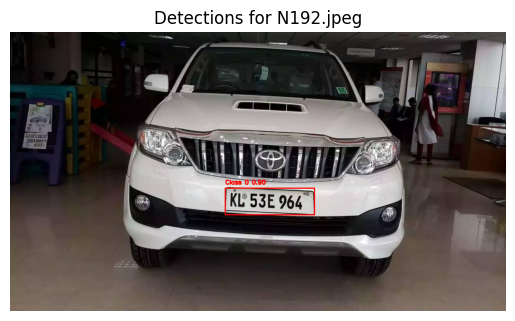


image 1/1 /kaggle/working/dataset/images/test/N126.jpeg: 384x640 1 number_plate, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


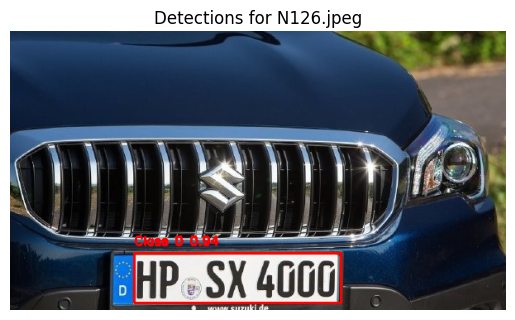


image 1/1 /kaggle/working/dataset/images/test/N113.jpeg: 480x640 1 number_plate, 40.0ms
Speed: 2.0ms preprocess, 40.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


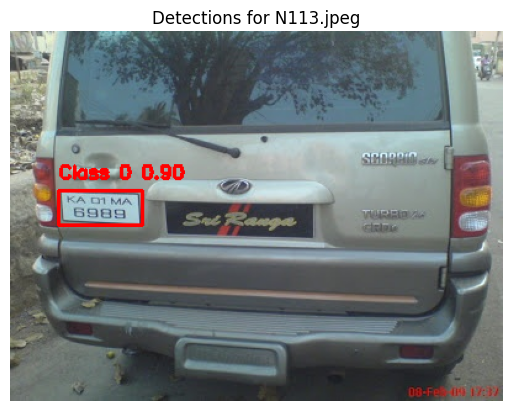


image 1/1 /kaggle/working/dataset/images/test/N112.jpeg: 448x640 1 number_plate, 42.2ms
Speed: 1.9ms preprocess, 42.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


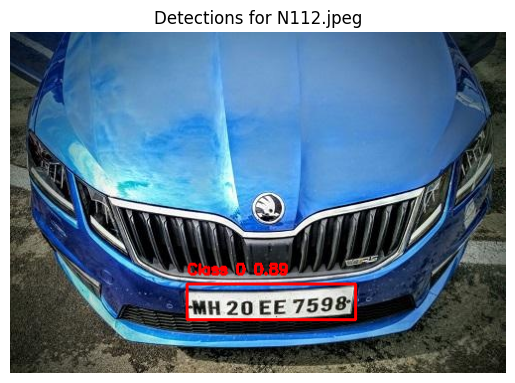


image 1/1 /kaggle/working/dataset/images/test/N97.jpeg: 416x640 1 number_plate, 43.0ms
Speed: 1.7ms preprocess, 43.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict


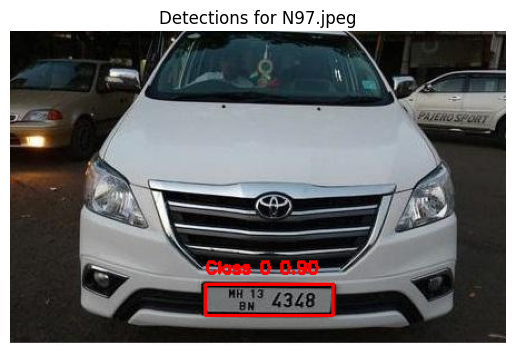


image 1/1 /kaggle/working/dataset/images/test/N237.jpeg: 384x640 1 number_plate, 9.6ms
Speed: 2.6ms preprocess, 9.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


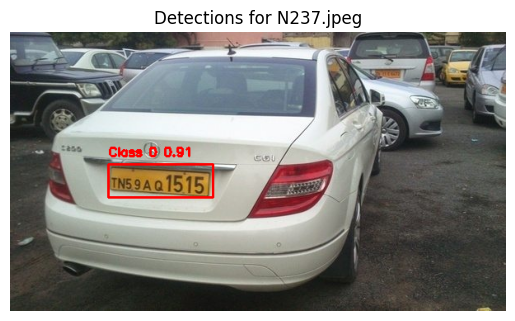


image 1/1 /kaggle/working/dataset/images/test/N27.jpeg: 384x640 1 number_plate, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


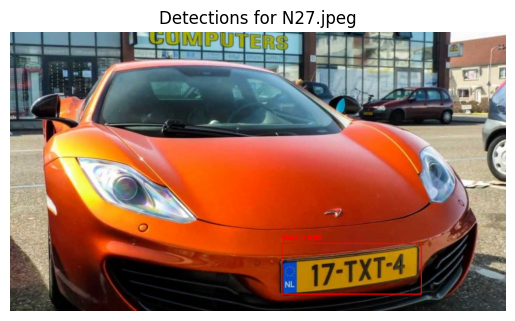


image 1/1 /kaggle/working/dataset/images/test/N214.jpeg: 448x640 1 number_plate, 11.7ms
Speed: 2.9ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


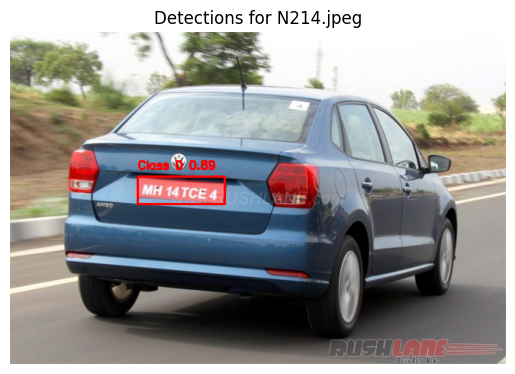


image 1/1 /kaggle/working/dataset/images/test/N187.jpeg: 480x640 1 number_plate, 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


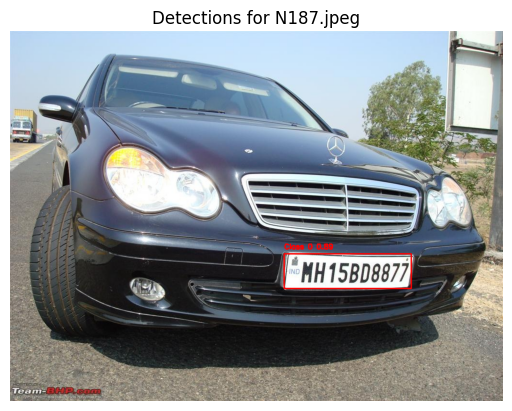


image 1/1 /kaggle/working/dataset/images/test/N98.jpeg: 320x640 1 number_plate, 39.8ms
Speed: 2.3ms preprocess, 39.8ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs/detect/predict


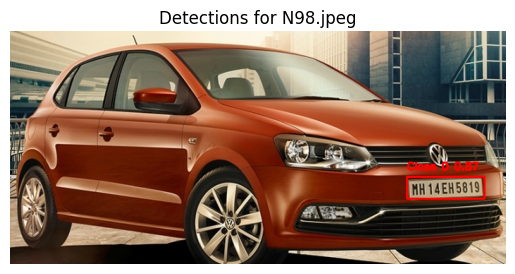


image 1/1 /kaggle/working/dataset/images/test/N6.jpeg: 384x640 1 number_plate, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


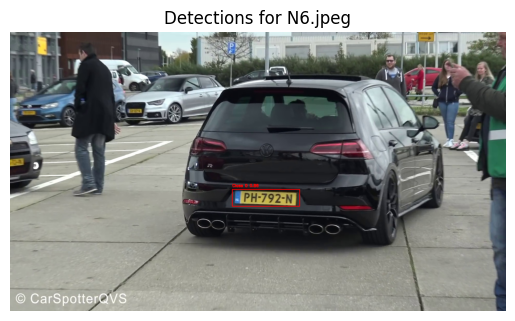


image 1/1 /kaggle/working/dataset/images/test/N166.jpeg: 256x640 1 number_plate, 39.0ms
Speed: 1.5ms preprocess, 39.0ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 640)
Results saved to runs/detect/predict


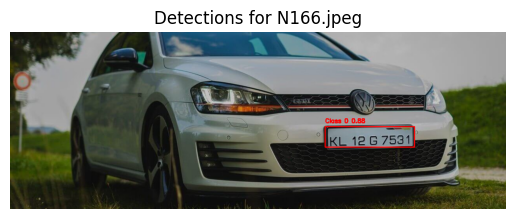


image 1/1 /kaggle/working/dataset/images/test/N90.jpeg: 512x640 1 number_plate, 39.6ms
Speed: 2.3ms preprocess, 39.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict


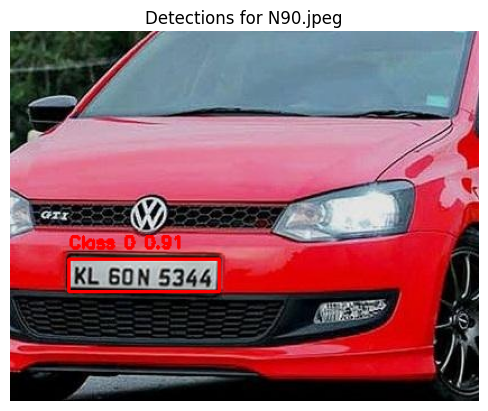


image 1/1 /kaggle/working/dataset/images/test/N195.jpeg: 480x640 1 number_plate, 9.8ms
Speed: 3.1ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


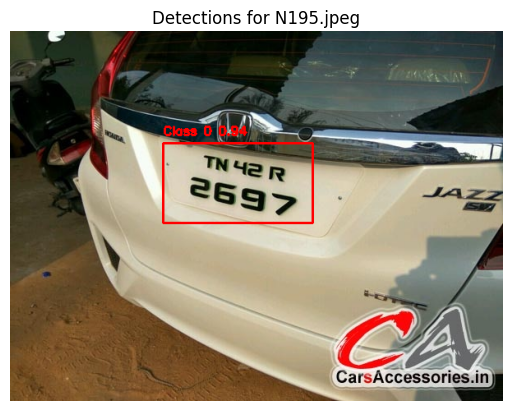


image 1/1 /kaggle/working/dataset/images/test/N67.jpeg: 448x640 1 number_plate, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


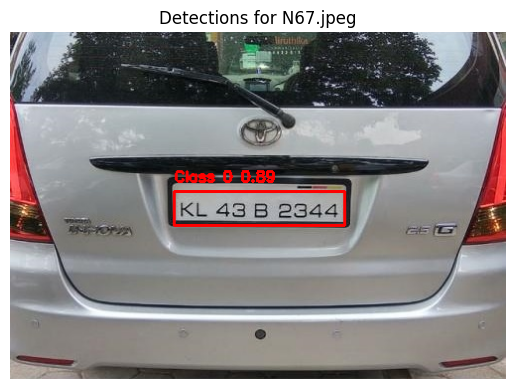


image 1/1 /kaggle/working/dataset/images/test/N223.jpeg: 480x640 1 number_plate, 8.2ms
Speed: 2.2ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


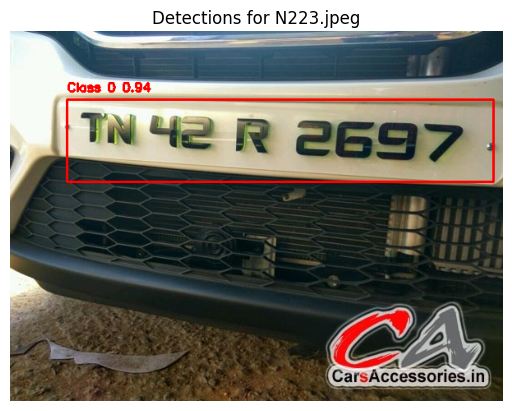


image 1/1 /kaggle/working/dataset/images/test/N245.jpeg: 512x640 1 number_plate, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict


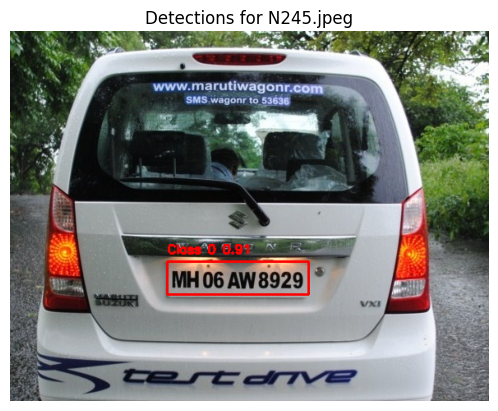


image 1/1 /kaggle/working/dataset/images/test/N34.jpeg: 384x640 1 number_plate, 8.4ms
Speed: 2.2ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


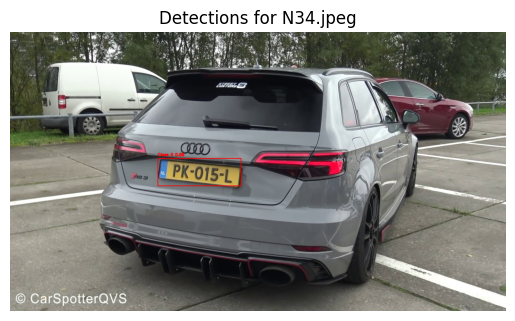


image 1/1 /kaggle/working/dataset/images/test/N24.jpeg: 512x640 1 number_plate, 9.8ms
Speed: 3.0ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/detect/predict


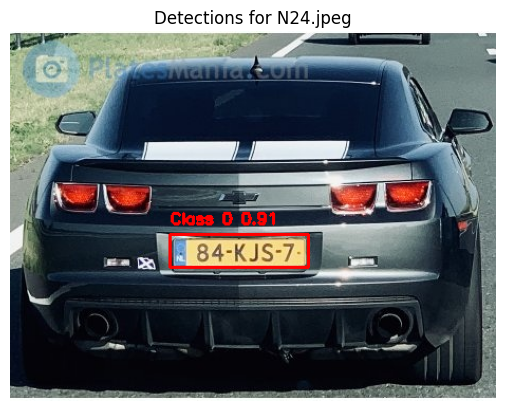


image 1/1 /kaggle/working/dataset/images/test/N32.jpeg: 416x640 1 number_plate, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict


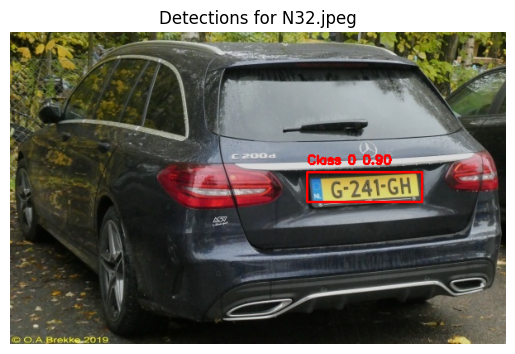


image 1/1 /kaggle/working/dataset/images/test/N127.jpeg: 448x640 1 number_plate, 9.9ms
Speed: 2.6ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


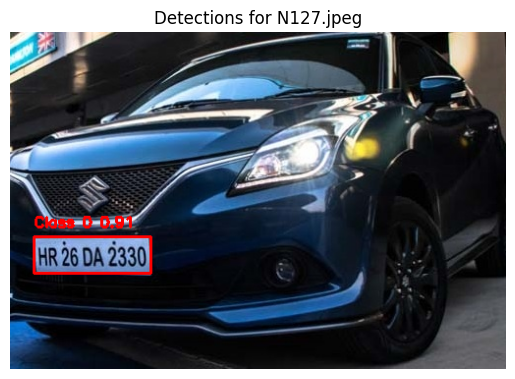


image 1/1 /kaggle/working/dataset/images/test/N202.jpeg: 480x640 1 number_plate, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


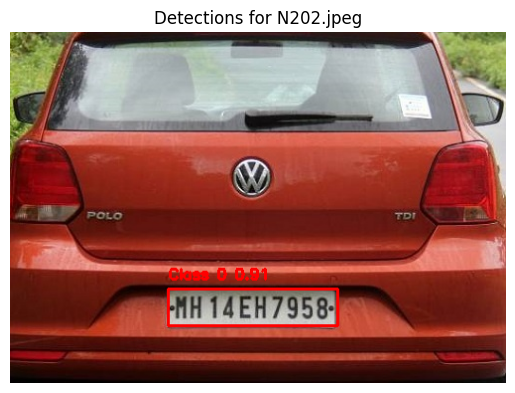


image 1/1 /kaggle/working/dataset/images/test/N151.jpeg: 640x640 1 number_plate, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


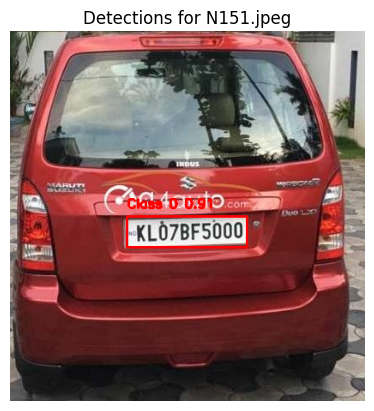

In [31]:
import matplotlib.pyplot as plt

test_dataset = '/kaggle/input/anpr-test'
model = YOLO('/kaggle/working/model/yolov8_model.pt')  

output_dir = '/kaggle/working/ANPR_Test_Results'
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(test_images_dir):
    if filename.endswith(('.jpeg', '.jpg', '.png')):  
        image_path = os.path.join(test_images_dir, filename)

        results = model.predict(source=image_path, save=True, save_dir=output_dir)

        if results:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

            for result in results:
                boxes = result.boxes
                if len(boxes) == 0:
                    print(f"No detections for {filename}.")
                    continue 

                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()  
                    confidence = box.conf[0].cpu().item()  
                    class_id = int(box.cls[0].cpu().item()) 

                    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
                    label = f'Class {class_id} {confidence:.2f}'
                    cv2.putText(img, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            plt.imshow(img)
            plt.title(f'Detections for {filename}')
            plt.axis('off')
            plt.show()
        else:
            print(f"No results for {filename}.")
     

# Working Great!!!